In [6]:
from collections import deque, namedtuple
from copy import deepcopy
import random, math
from itertools import count

import torch
from torch import nn, optim
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import gym

In [7]:
def mlp(layer_config, activation, output_activation=nn.Identity):
    layers = []
    for i in range(len(layer_config) - 1):
        activation = activation if i < len(layer_config) - 2 else output_activation
        layers += [nn.Linear(layer_config[i], layer_config[i + 1]), activation()]
    return nn.Sequential(*layers)

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_layer_config, activation):
        super().__init__()
        layer_config = [state_dim, *hidden_layer_config, action_dim]
        self.policy = mlp(layer_config, activation, output_activation=nn.Tanh)

    def forward(self, state):
        return self.policy(state)

class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_layer_config, activation):
        super().__init__()
        layer_config = [state_dim + action_dim, *hidden_layer_config, 1]
        self.q = mlp(layer_config, activation)

    def forward(self, state, action):
        return self.q(torch.cat([state, action], dim=-1))

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim=1, hidden_layer_config=(128, 128), activation=nn.ReLU):
        super().__init__()
        self.actor = PolicyNet(state_dim, action_dim, hidden_layer_config, activation)
        self.critic = QNet(state_dim, action_dim, hidden_layer_config, activation)
    
    def get_action(self, state):
        with torch.no_grad():
            return self.actor(state)

In [8]:
Transition = namedtuple(
    typename='Transtiion',
    field_names=('state', 'action', 'reward', 'next_state', 'done')
)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque([], maxlen=capacity)
    
    def push(self, *args):
        def transform(data):
            data = torch.tensor(data).float()
            return data if data.ndim > 1 else data.view(1, -1)
        self.buffer.append(Transition(*map(transform, args)))
    
    def sample(self, batch_size=32):
        sample = random.sample(population=self.buffer, k=batch_size)
        return Transition(*map(torch.cat, zip(*sample))) # Bind transition fields under batch dimension respectively
    
    def __len__(self):
        return len(self.buffer)

<img src="ddpg.png" width="1006px" height="744px"></img>

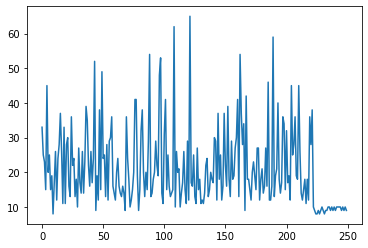

In [9]:
buffer_capacity = 10000
gamma = 0.99
lr_q = 1e-3
lr_policy = 1e-3
polyak = 0.995
action_noise = 0.05
n_episodes = 10000
prelearning_steps = 5000
batch_size = 64

env_fn = lambda: gym.make('CartPole-v1')

# Initialize environment
env, test_env = env_fn(), env_fn()
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# Initialize Actor-Critic networks and corresponding target networks
ac = ActorCritic(state_dim=state_dim)
target_ac = deepcopy(ac)
for p in target_ac.parameters():
    p.requires_grad = False

# Initialize replay buffer
replay_buffer = ReplayBuffer(capacity=buffer_capacity)

def get_q_loss(data: Transition):
    done_mask = torch.ones_like(data.done) - data.done
    q = ac.critic(data.state, data.action)
    with torch.no_grad():
        q_prime = target_ac.critic(data.next_state, target_ac.actor(data.next_state))
        bellman_backup = data.reward + done_mask * gamma * q_prime
    
    return F.mse_loss(q, bellman_backup)

def get_policy_loss(data: Transition):
    q = ac.critic(data.state, ac.actor(data.state))
    return -q.mean() # Lower state-action value represents higher loss of action

q_optimizer = optim.Adam(ac.critic.parameters(), lr=lr_q)
policy_optimizer = optim.Adam(ac.actor.parameters(), lr=lr_policy)

def update(data: Transition):
    q_optimizer.zero_grad()
    q_loss = get_q_loss(data)
    q_loss.backward()
    q_optimizer.step()

    for p in ac.critic.parameters():
        p.requires_grad = False

    policy_optimizer.zero_grad()
    policy_loss = get_policy_loss(data)
    policy_loss.backward()
    policy_optimizer.step()
    
    for p in ac.critic.parameters():
        p.requires_grad = True

    with torch.no_grad():
        for p, target_p in zip(ac.parameters(), target_ac.parameters()):
            target_p.data.mul_(polyak)
            target_p.data.add_((1 - polyak) * p.data)

def get_action(state, noise_scale):
    action = ac.actor(state)
    action += noise_scale * random.randrange(n_actions)
    return torch.clip(action, min=0, max=n_actions - 1).round().long().item()


durations = []
for ep in range(1, n_episodes + 1):
    state = env.reset()

    for t in count(1):
        if len(replay_buffer) > prelearning_steps:
            action = get_action(torch.from_numpy(state).float(), noise_scale=action_noise)
        else:
            action = env.action_space.sample()
        
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state

        if len(replay_buffer) > prelearning_steps:
            sample = replay_buffer.sample(batch_size=batch_size)
            update(sample)

        if done:
            durations.append(t)
            break

    if ep % 250 == 0:
        plt.plot(durations)
        plt.show()